Model prediction (interaction probability): 0.5268421769142151


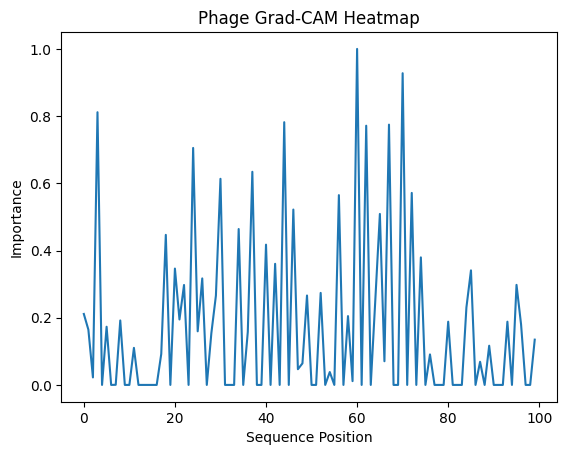

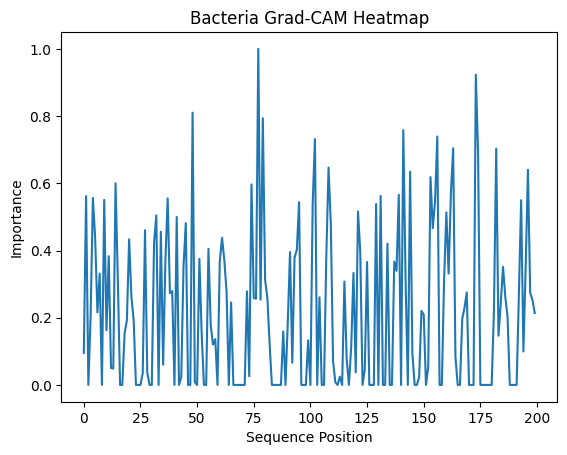

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the dummy dual-input 1D CNN model
class DualInputCNN(nn.Module):
    def __init__(self, phage_input_length=100, bacteria_input_length=200):
        super(DualInputCNN, self).__init__()
        # Phage branch: assume 4 channels (e.g., one-hot encoded nucleotides)
        self.phage_branch = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=3, padding=1),  # Target layer for Grad-CAM
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # Bacteria branch: same idea
        self.bacteria_branch = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=3, padding=1),  # Target layer for Grad-CAM
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # Calculate the resulting lengths after pooling
        self.phage_feat_length = phage_input_length // 2
        self.bacteria_feat_length = bacteria_input_length // 2
        
        # Fully connected layers after concatenating flattened branch outputs
        self.fc = nn.Sequential(
            nn.Linear(16 * self.phage_feat_length + 16 * self.bacteria_feat_length, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, phage, bacteria):
        # Process each branch separately
        phage_feat = self.phage_branch(phage)         # shape: (batch, 16, phage_feat_length)
        bacteria_feat = self.bacteria_branch(bacteria)  # shape: (batch, 16, bacteria_feat_length)
        
        # Flatten and concatenate features from both branches
        phage_flat = phage_feat.view(phage_feat.size(0), -1)
        bacteria_flat = bacteria_feat.view(bacteria_feat.size(0), -1)
        combined = torch.cat([phage_flat, bacteria_flat], dim=1)
        
        # Final prediction: interaction probability
        out = self.fc(combined)
        return out

# Updated Grad-CAM module for 1D CNNs
class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: The overall model.
        target_layer: The convolutional layer (from one branch) on which to register hooks.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register forward hook to capture activations and attach a hook to capture gradients.
        self.target_layer.register_forward_hook(self.save_activation)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
        # Register hook on the output tensor to capture gradients during backpropagation.
        output.register_hook(self.save_gradient)
    
    def save_gradient(self, grad):
        self.gradients = grad.detach()
    
    def __call__(self, model_output):
        """
        Given the model output (a scalar), this function computes the Grad-CAM heatmap.
        """
        # Zero out gradients
        self.model.zero_grad()
        # Backpropagate from the model output
        model_output.backward(retain_graph=True)
        
        # Ensure that gradients have been captured
        if self.gradients is None:
            raise ValueError("Gradients have not been captured. Check the hook registration.")
        
        # Compute the weights: global average pooling over the temporal dimension (dim=2)
        weights = torch.mean(self.gradients, dim=2, keepdim=True)  # shape: (batch, channels, 1)
        
        # Compute the weighted combination of activations
        cam = torch.sum(weights * self.activations, dim=1)  # shape: (batch, time)
        cam = F.relu(cam)  # Apply ReLU to keep only positive contributions
        
        # Normalize the heatmap between 0 and 1
        cam_min = cam.min(dim=1, keepdim=True)[0]
        cam_max = cam.max(dim=1, keepdim=True)[0]
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        
        return cam

# ---------------------------
# Dummy testing and visualization
# ---------------------------
if __name__ == '__main__':
    torch.manual_seed(42)
    
    # Define dummy input sizes: batch size of 1
    batch_size = 1
    phage_input_length = 100      # e.g., 100 base pairs (for illustration)
    bacteria_input_length = 200   # e.g., 200 base pairs
    
    # Create dummy inputs with 4 channels (simulating one-hot encoded sequences)
    phage_input = torch.randn(batch_size, 4, phage_input_length)
    bacteria_input = torch.randn(batch_size, 4, bacteria_input_length)
    
    # Instantiate the model and set to evaluation mode
    model = DualInputCNN(phage_input_length, bacteria_input_length)
    model.eval()
    
    # **Register Grad-CAM hooks BEFORE the forward pass**
    gradcam_phage = GradCAM(model, model.phage_branch[0])
    gradcam_bacteria = GradCAM(model, model.bacteria_branch[0])
    
    # Forward pass (after hook registration)
    output = model(phage_input, bacteria_input)
    print("Model prediction (interaction probability):", output.item())
    
    # Compute Grad-CAM heatmaps using the model's output (shared by both branches)
    cam_phage = gradcam_phage(output)        # shape: (batch, feature_length)
    cam_bacteria = gradcam_bacteria(output)    # shape: (batch, feature_length)
    
    # Upsample the CAM to the original input length using linear interpolation
    cam_phage_upsampled = F.interpolate(cam_phage.unsqueeze(1), size=phage_input_length, mode='linear', align_corners=False)
    cam_bacteria_upsampled = F.interpolate(cam_bacteria.unsqueeze(1), size=bacteria_input_length, mode='linear', align_corners=False)
    
    # Convert to numpy arrays for plotting
    cam_phage_np = cam_phage_upsampled.squeeze().cpu().numpy()
    cam_bacteria_np = cam_bacteria_upsampled.squeeze().cpu().numpy()
    
    # Plot the Grad-CAM heatmap for the phage sequence
    plt.figure()
    plt.plot(cam_phage_np)
    plt.title("Phage Grad-CAM Heatmap")
    plt.xlabel("Sequence Position")
    plt.ylabel("Importance")
    plt.show()
    
    # Plot the Grad-CAM heatmap for the bacteria sequence
    plt.figure()
    plt.plot(cam_bacteria_np)
    plt.title("Bacteria Grad-CAM Heatmap")
    plt.xlabel("Sequence Position")
    plt.ylabel("Importance")
    plt.show()
